## 1 - Setup environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip -q install pdf2image
!sudo apt-get install poppler-utils
!pip install pdfplumber
!pip install spacy_transformers
!pip install tqdm

%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.8/225.8 GB disk)


In [3]:
from tqdm import tqdm
from pdf2image import convert_from_path
from ultralytics import YOLO
import shutil
import glob
import spacy

import os
import pdfplumber
import re
import pandas as pd
import numpy as np
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

In [4]:
# Functions
def create_classified_folder(classified_folder):
    classes = ['appendix', 'cover', 'description', 'description and table',
              'graph', 'info', 'list figure', 'list table', 'table', 'table content'
              ]
    for c in classes:
        os.makedirs(classified_folder + '/' + c, exist_ok=True)

## 2 - Specify PDF report

In [5]:
# Specify PDF file
report = '/content/WF-Gas-Condensate-REC-Sample (CL-63169).pdf'


## 3 - Convert PDF to JPG pages

In [6]:
# Output folder
output_folder = '/content/report_jpg'
os.makedirs(output_folder, exist_ok=True)

# Convert PDF to images
print("Converting PDF to images...")
images = convert_from_path(report)

# Save each image to the output folder
image_paths = []
for i, image in enumerate(images):
    output_file = os.path.join(output_folder, f'page_{i + 1}.jpg')
    image.save(output_file, 'JPEG')
    image_paths.append(output_file)  # Store the file path for creating a table

print(f"All pages have been saved to {output_folder}")

Converting PDF to images...
All pages have been saved to /content/report_jpg


## 4 - Classifying pages

In [7]:
# Specify classifier model YOLO
classifier = YOLO('/content/drive/MyDrive/Whitson/Report OCR/MODEL/Page_Classifier.pt')

# Classify pages
results = classifier.predict('/content/report_jpg')



image 1/103 /content/report_jpg/page_1.jpg: 128x128 cover 1.00, table 0.00, info 0.00, description and table 0.00, description 0.00, 222.8ms
image 2/103 /content/report_jpg/page_10.jpg: 128x128 table 1.00, list figure list table 0.00, list figure 0.00, list table 0.00, description and table 0.00, 74.0ms
image 3/103 /content/report_jpg/page_100.jpg: 128x128 info 1.00, table 0.00, graph 0.00, cover 0.00, appendix 0.00, 73.0ms
image 4/103 /content/report_jpg/page_101.jpg: 128x128 table 1.00, table content 0.00, description and table 0.00, info 0.00, list table 0.00, 73.4ms
image 5/103 /content/report_jpg/page_102.jpg: 128x128 table 1.00, table content 0.00, info 0.00, description and table 0.00, list table 0.00, 72.2ms
image 6/103 /content/report_jpg/page_103.jpg: 128x128 table 1.00, description and table 0.00, list figure list table 0.00, table content 0.00, info 0.00, 84.9ms
image 7/103 /content/report_jpg/page_11.jpg: 128x128 table 1.00, table content 0.00, list figure list table 0.00

In [8]:
page_category = []
page_number = []

for result in results:
    # Extract the predicted class and image path
    id = result.probs.top1
    name = result.names[id]  # Predicted class name
    image_path = result.path
    page_category.append(name)

    # Page number
    page_no = int(image_path.split('/')[-1].split('.')[0].split('_')[-1])
    page_number.append(page_no)

# Create dictionary
page_dict = dict(zip(page_number, page_category))

## 5 - Extract text from PDF pages

In [9]:
# Function to add space between concatenated words
def add_space_to_text(text):
    return re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

# Initialize an empty list to store extracted text per page
text = []

try:
    # Open the PDF file
    with pdfplumber.open(report) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text()
            if page_text:
                page_text = add_space_to_text(page_text)  # Add spaces to concatenated words
                text.append(page_text)

except Exception as e:
    print(f"Error processing report {report}: {e}")

In [10]:
# Create dataframe
df = pd.DataFrame()
df['page_no'] = np.arange(1, len(text) + 1)
df['extracted_text'] = text

# Map page number with page category
df['page_category'] = df['page_no'].map(page_dict)

# Replace \n with a space in each row of the 'extracted_text' column
df['extracted_text'] = df['extracted_text'].str.replace('\n', ' ', regex=False)

df

,page_no,extracted_text,page_category
0,1,ENCANA CORPORATION WAHIGAN RESERVOIR WELL: 08-...,cover
1,2,ENCANA CORPORATION CONSTANT VOLUME DEPLETION T...,table content
2,3,ENCANA CORPORATION LIST OF TABLES TABLE 1 SAMP...,list table
3,4,ENCANA CORPORATION LIST OF FIGURES FIGURE 1 CO...,list figure
4,5,ENCANA CORPORATION RESULTS AND DISCUSSION The ...,description and table
...,...,...,...
98,99,SAMPLE VALIDATION TABLE B62 ENCANA CORPORATION...,info
99,100,SAMPLE VALIDATION TABLE B63 ENCANA CORPORATION...,info
100,101,SAMPLE VALIDATION TABLE B64 ENCANA CORPORATION...,table
101,102,SAMPLE VALIDATION TABLE B65 ENCANA CORPORATION...,table


## 6 - Run NER on each page text

In [11]:
# Load the trained model
model_folder = "/content/drive/MyDrive/Whitson/Report OCR/MODEL/NER_Model_Condensate_Duvernay/model-best"
nlp = spacy.load(model_folder)

# Define the labels you want to extract
labels = ["EXPERIMENT", "ANALYSIS", "SAMPLE", "FLUID"]

# Create empty columns in the DataFrame for each label
for label in labels:
    df[label] = ""

# Iterate through the DataFrame
for index, row in df.iterrows():
    # Apply the NLP model to the extracted_text column
    doc = nlp(row['extracted_text'])

    # Initialize a dictionary to store entities for this row
    row_entities = {label: [] for label in labels}

    # Extract entities from the text
    for ent in doc.ents:
        if ent.label_ in labels:
            row_entities[ent.label_].append(ent.text)

    # Fill the DataFrame columns with extracted entities
    for label in labels:
        df.at[index, label] = ", ".join(row_entities[label])

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [12]:
df_table = df[df['page_category'] == 'table']

df_table.head()

,page_no,extracted_text,page_category,EXPERIMENT,ANALYSIS,SAMPLE,FLUID
7,8,ENCANA CORPORATION TABLE 2 ENCANA CORPORATION ...,table,,COMPOSITIONAL ANALYSIS,RECOMBINED SAMPLE,RESERVOIR FLUID
8,9,ENCANA CORPORATION TABLE 3 ENCANA CORPORATION ...,table,,FLUID COMPRESSIBILITY,RECOMBINED SAMPLE,
9,10,ENCANA CORPORATION TABLE 4 ENCANA CORPORATION ...,table,CONSTANT COMPOSITION EXPANSION,,RECOMBINED SAMPLE,
10,11,ENCANA CORPORATION TABLE 5 ENCANA CORPORATION ...,table,CONSTANT VOLUME DEPLETION,,RECOMBINED SAMPLE,
11,12,ENCANA CORPORATION TABLE 6 ENCANA CORPORATION ...,table,CONSTANT VOLUME DEPLETION,PRODUCED WELLSTREAM PROPERTIES,RECOMBINED SAMPLE,


## 7 - Go to very specific page based on query

In [44]:
df_table[df_table['ANALYSIS'] == 'PRODUCED WELLSTREAM COMPOSITIONAL ANALYSIS']

,page_no,extracted_text,page_category,EXPERIMENT,ANALYSIS,SAMPLE,FLUID
12,13,ENCANA CORPORATION TABLE 7 ENCANA CORPORATION ...,table,CVD,PRODUCED WELLSTREAM COMPOSITIONAL ANALYSIS,RECOMBINED SAMPLE,


In [26]:
df.ANALYSIS.unique()

array(['', 'SAMPLE COLLECTION DATA, COMPOSITIONAL ANALYSIS, CONSTANT COMPOSITION EXPANSION, PRODUCED WELLSTREAM PROPERTIES, PRODUCED WELLSTREAM COMPOSITIONAL ANALYSIS, COMPOSITIONAL YIELDS',
       'CONSTANT COMPOSITION EXPANSION, CONSTANT COMPOSITION EXPANSION, CUMULATIVE PRODUCED FLUID, CUMULATIVE PRODUCED LIQUID, CONDENSATE-, GAS DEVIATION FACTORS, WELLSTREAM DENSITY, WELLSTREAM VISCOSITY, WELLSTREAM COMPOSITION', 'RESULTS AND DISCUSSION', 'RESERVOIR CONDITIONS Reservoir', 'COMPOSITIONAL ANALYSIS',
       'FLUID COMPRESSIBILITY', 'PRODUCED WELLSTREAM PROPERTIES', 'PRODUCED WELLSTREAM COMPOSITIONAL ANALYSIS', 'WELLSTREAM COMPOSITIONS', 'COMPOSITIONAL RECOVERY', 'CUMULATIVE PRODUCED FLUID', 'CUMULATIVE PRODUCED LIQUID', 'CONDENSATE-', 'GAS DEVIATION FACTORS', 'WELLSTREAM DENSITY', 'WELLSTREAM VISCOSITY',
       'WELLSTREAM COMPOSITION', 'GAS SAMPLE COLLECTION DATA', 'OIL SAMPLE COLLECTION DATA', 'SAMPLE COLLECTION DATA', 'MAIN PVT RESULTS INITIAL RESERVOIR CONDITIONS Reservoir'], dtyp

Page: 12


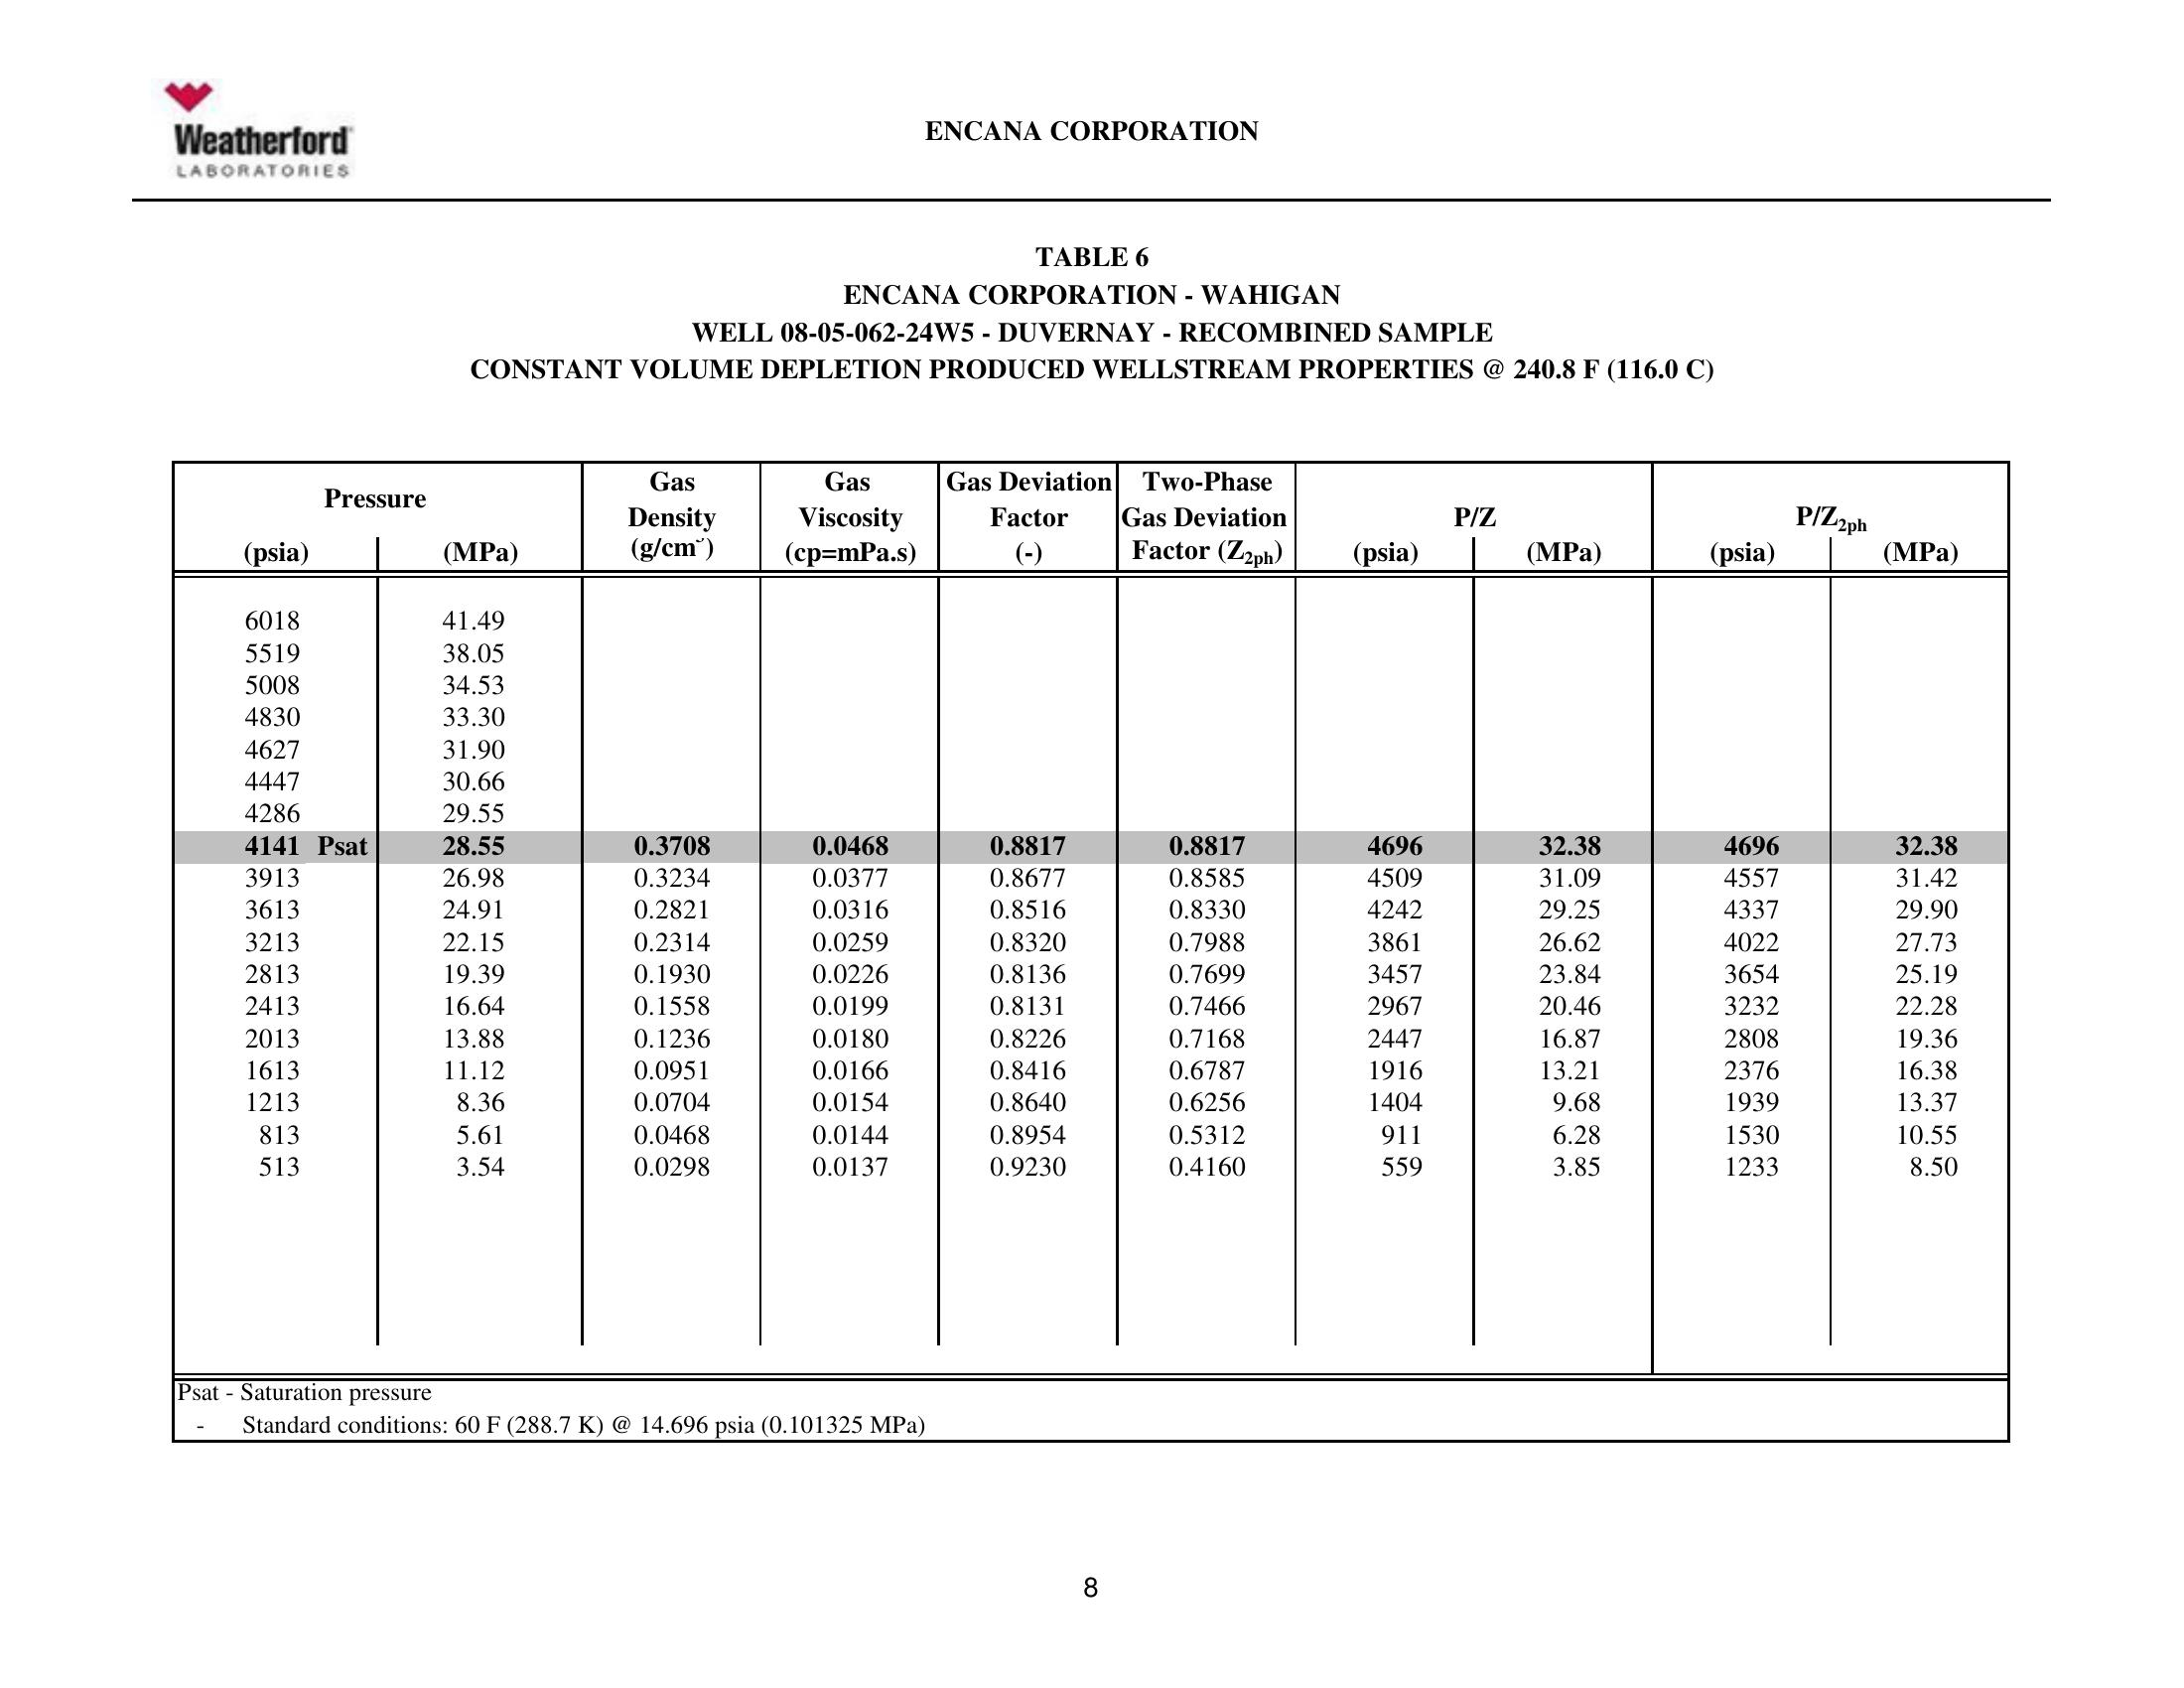

In [47]:
# @title Select what you want to search
query = "CVD - Wellstream Properties"  # @param ['Compositional data - Recombined Fluid', 'Compositional data - Flashed Oil', 'Compositional data - Flashed Gas', 'CCE - Recombined Fluid', 'CVD - Fluid Recovery', 'CVD - Wellstream Properties', 'CVD - Wellstream Compositions']

# Create rule
### LATER THIS RULE CAN BE A MACHINE LEARNING IF REPORT IS DIVERSE
if query == 'Compositional data - Recombined Fluid':
  ANALYSIS = 'COMPOSITIONAL ANALYSIS'
  SAMPLE = 'RECOMBINED SAMPLE'
  FLUID = 'RESERVOIR FLUID'
  df_query = df_table[(df_table['ANALYSIS'] == ANALYSIS) & (df_table['SAMPLE'] == SAMPLE) & (df_table['FLUID'] == FLUID)]


elif query == 'Compositional data - Flashed Oil':
  ANALYSIS = 'COMPOSITIONAL ANALYSIS'
  SAMPLE = 'RECOMBINED SAMPLE'
  FLUID = 'FLASHED OIL'
  df_query = df_table[(df_table['ANALYSIS'] == ANALYSIS) & (df_table['SAMPLE'] == SAMPLE) & (df_table['FLUID'] == FLUID)]


elif query == 'Compositional data - Flashed Gas':
  ANALYSIS = 'COMPOSITIONAL ANALYSIS'
  SAMPLE = 'RECOMBINED SAMPLE'
  FLUID = 'FLASHED GAS'
  df_query = df_table[(df_table['ANALYSIS'] == ANALYSIS) & (df_table['SAMPLE'] == SAMPLE) & (df_table['FLUID'] == FLUID)]


elif query == 'CCE - Recombined Fluid':
  EXPERIMENT = 'CONSTANT COMPOSITION EXPANSION'
  SAMPLE = 'RECOMBINED SAMPLE'
  df_query = df_table[(df_table['EXPERIMENT'] == EXPERIMENT) & (df_table['SAMPLE'] == SAMPLE)]

elif query == 'CVD - Fluid Recovery':
  EXPERIMENT = 'CONSTANT VOLUME DEPLETION'
  ANALYSIS = 'FLUID RECOVERY'
  SAMPLE = 'RECOMBINED SAMPLE'
  df_query = df_table[(df_table['EXPERIMENT'] == EXPERIMENT) & (df_table['ANALYSIS'] == ANALYSIS) & (df_table['SAMPLE'] == SAMPLE)]

elif query == 'CVD - Wellstream Properties':
  EXPERIMENT = 'CONSTANT VOLUME DEPLETION'
  ANALYSIS = 'PRODUCED WELLSTREAM PROPERTIES'
  SAMPLE = 'RECOMBINED SAMPLE'
  df_query = df_table[(df_table['EXPERIMENT'] == EXPERIMENT) & (df_table['ANALYSIS'] == ANALYSIS) & (df_table['SAMPLE'] == SAMPLE)]

elif query == 'CVD - Wellstream Compositions':
  EXPERIMENT = 'CONSTANT VOLUME DEPLETION'
  ANALYSIS_1 = 'PRODUCED WELLSTREAM COMPOSITIONAL ANALYSIS'
  ANALYSIS_2 = 'WELLSTREAM COMPOSITIONS'
  SAMPLE = 'RECOMBINED SAMPLE'
  df_query = df_table[(df_table['EXPERIMENT'] == EXPERIMENT) & (df_table['ANALYSIS'] == ANALYSIS_1) & (df_table['SAMPLE'] == SAMPLE)]

# Get page number
query_page = df_query['page_no'].values

for page in query_page:
  print('Page:', page)

  # Retrieve from report_jpg folder
  jpg_folder = '/content/report_jpg'
  page_path = jpg_folder + '/page_' + str(page) + '.jpg'

  # Show image
  image = cv2.imread(page_path)
  cv2_imshow(image)